# Face Detection

In [266]:
#import necessary modules

import numpy as np
import pandas as pd
import matplotlib as plt
import cv2
import os

## Load images from dir


In [267]:
#images path
img_dir = 'train_images'
# Path to the folder containing test images
test_img_dir = 'test_images'
# Create a mapping from folder names to integer labels
label_map = {'wmaathai': 1, 'others': 0}

## Train FaceRecognizer Model

In [268]:
# initialize empty lists for training images and image-labels
faces = []
ids = []


In [269]:
# Load Haar Cascade classifiers for frontal and side faces
front_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
side_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [270]:
# Set to track processed face coordinates (to avoid duplicates)
processed_faces_coordinates = set()

In [ ]:
# train FaceRecognizer model
for root, dirs, files in os.walk(img_dir):
    for filename in files:
    
        # Check if the file is an image (JPG, PNG, JPEG)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, filename)  # Get full image path relative to root
        
            # Read the image
            img = cv2.imread(image_path)

            # Skip invalid images
            if img is None:
                print(f"Failed to load image {image_path}")
                continue

            # Convert the image to grayscale (Haar cascades work with grayscale images)
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Detect frontal faces
            front_faces = front_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))

            # Detect side faces
            side_faces = side_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))

            print(f"Detected {len(front_faces)} front face(s) and {len(side_faces)} side face(s) in {image_path}")

            #skip invalid images
            if img is None:
                print(f"Failed to load image {image_path}")
                continue

            # Combine both frontal and side faces into one list only if they are valid
            all_faces = []
            if len(front_faces) > 0:
                all_faces.extend(front_faces)
            if len(side_faces) > 0:
                all_faces.extend(side_faces)
            
            # Process each detected face
            for (x, y, w, h) in all_faces:
                if (x, y, w, h) in processed_faces_coordinates:
                    continue  # Skip if face already processed

                processed_faces_coordinates.add((x, y, w, h))  # Add coordinates to avoid duplicate processing
                face_region = gray_img[y:y + h, x:x + w]  # Extract face region

                # Detect eyes within the detected face region
                eyes = eye_cascade.detectMultiScale(face_region, scaleFactor=1.1, minNeighbors=3, minSize=(40, 40))

                if len(eyes) > 0:  # If eyes are detected, process this face
                    faces.append(face_region)  # Add the face to the list
                    label = os.path.basename(root)  # Folder name as the label
                    if label in label_map:
                        ids.append(label_map[label])  # Add corresponding label


## Face Detection
-consider if a face is not detected

In [ ]:
# Check if faces and ids are not empty before training
if len(faces) > 0 and len(ids) > 0:
    # Create and train the recognizer
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    recognizer.train(faces, np.array(ids))  # Train the recognizer with the faces and corresponding ids

    # Save the trained model
    recognizer.save('./trained/trained_model.yml')
    print("Model trained and saved successfully.")
else:
    print("No faces detected, model training skipped.")

In [273]:
# Train the recognizer
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(faces, np.array(ids))


In [ ]:
# Save the trained model
recognizer.save('trained/trained_model.yml')
print("Model trained and saved successfully.")


import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the trained model for face recognition (we'll use eye detection for recognition)
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read('./trained/trained_model.yml')  # Path to the trained model

# Path to the folder containing test images
test_img_dir = 'test_images'

# Initialize Haar Cascade classifiers for eyes
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Loop through the test images
for test_image_name in os.listdir(test_img_dir):
    test_image_path = os.path.join(test_img_dir, test_image_name)

    test_img = cv2.imread(test_image_path)
    if test_img is None:
        print(f"Failed to load image {test_image_path}")
        continue  # Skip invalid images

    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  # Convert test image to grayscale

    # Detect eyes in the grayscale image
    eyes = eye_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=3, minSize=(30, 30))

    print(f"Processing image: {test_image_name}")

    # If no eyes detected
    if len(eyes) == 0:
        print("No eyes detected")
        text = "unknown"
        color = (0, 0, 255)  # Red text for 'unknown'
        cv2.putText(test_img, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    else:
        # Process each detected eye
        for (ex, ey, ew, eh) in eyes:
            # Draw a rectangle around the detected eye region for debugging
            cv2.rectangle(test_img, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)  # Green rectangle for eye region

            # Extract the eye region (just as we do with faces in typical face recognition)
            eye_region = gray_img[ey:ey + eh, ex:ex + ew]  # Grayscale region for recognition

            # Recognize the eye region using the trained recognizer
            label, confidence = recognizer.predict(eye_region)

            # Log the label and confidence for debugging
            print(f"  Detected eyes with label: {label}, confidence: {confidence}")

            # Check if the confidence value is good (low confidence means a good match)
            if confidence < 100:  # Low confidence means a good match
                if label == 1:  # Check if label corresponds to 'wmaathai'
                    text = "wmaathai"  # Only show 'wmaathai' text
                    color = (0, 255, 0)  # Green text for 'wmaathai'
                else:
                    text = "not wmaathai"  # Show only 'not wmaathai' text
                    color = (0, 0, 255)  # Red text for 'not wmaathai'
            else:
                # If the confidence is too high, mark the face as unknown
                text = "unknown"  # Show only 'unknown' text
                color = (0, 0, 255)  # Red text for 'unknown'

            # Put text on the image
            cv2.putText(test_img, text, (ex, ey - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Convert the image to RGB (from BGR, OpenCV uses BGR format)
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(test_img_rgb)
    plt.axis('off')  # Hide axes
    plt.title(f"Test Image: {test_image_name}")  # Title with the image name
    plt.show()
 

Processing image: 1.jpg
No eyes detected within face region of 1.jpg


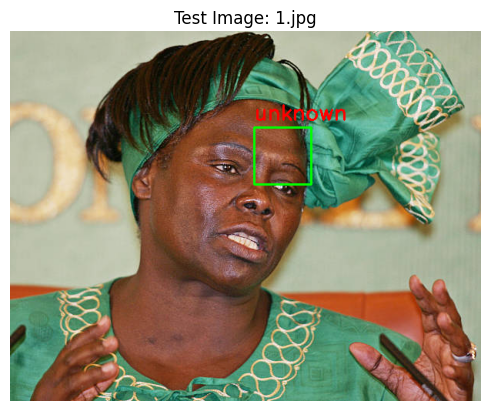

Processing image: 10.jpg
No eyes detected within face region of 10.jpg
No eyes detected within face region of 10.jpg


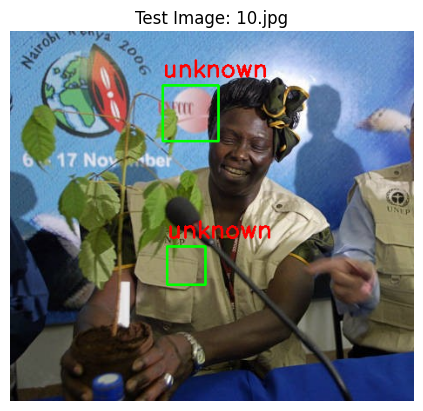

Processing image: 12.jpg
No eyes detected within face region of 12.jpg
No eyes detected within face region of 12.jpg


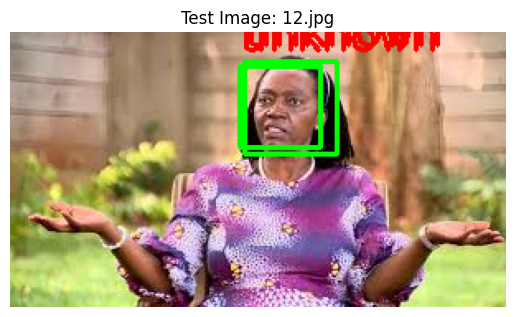

Processing image: 13.jpg
No eyes detected within face region of 13.jpg


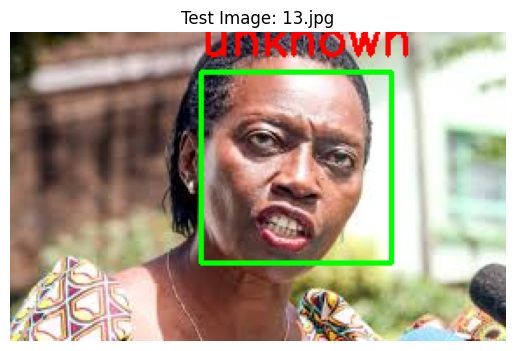

Processing image: 14.jpg
No eyes detected within face region of 14.jpg
No eyes detected within face region of 14.jpg


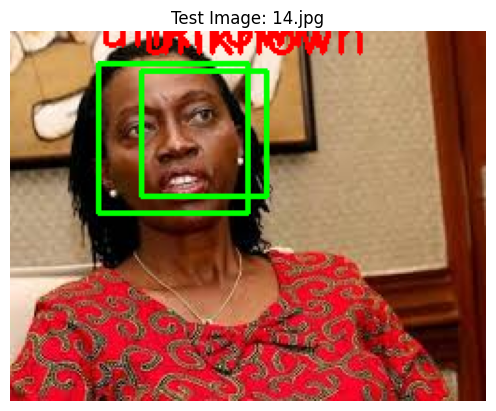

Processing image: 15.jpg
No eyes detected within face region of 15.jpg


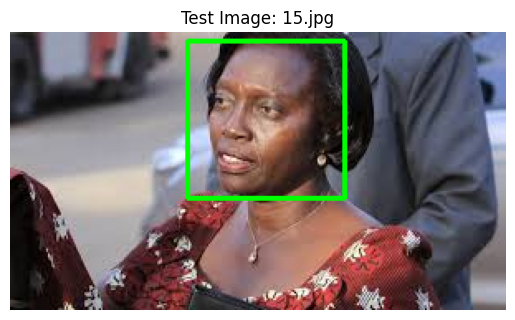

Processing image: 16.jpg
  Detected face with label: 0, confidence: 109.00038794268778


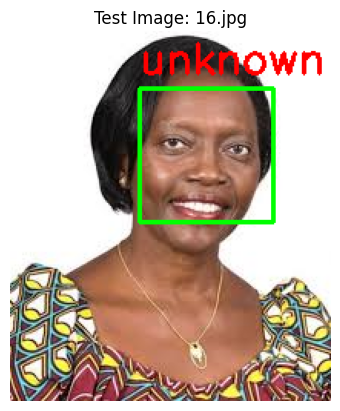

Processing image: 17.jpg
No faces detected in 17.jpg


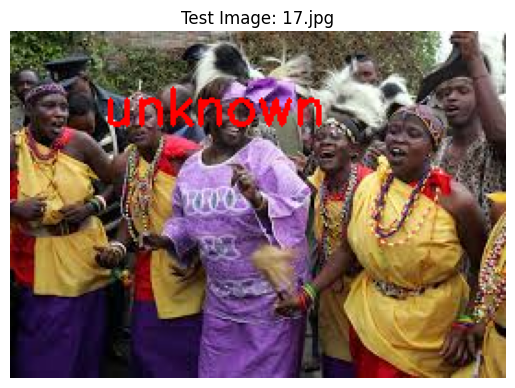

Processing image: 18.jpg
No eyes detected within face region of 18.jpg
  Detected face with label: 0, confidence: 92.67157909111287
  Detected face with label: 0, confidence: 87.15356577539502


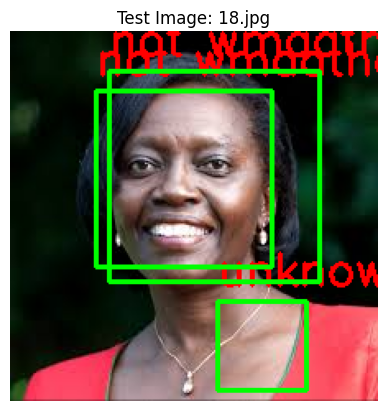

Processing image: 19.jpg
  Detected face with label: 0, confidence: 89.9045066166221
No eyes detected within face region of 19.jpg
No eyes detected within face region of 19.jpg


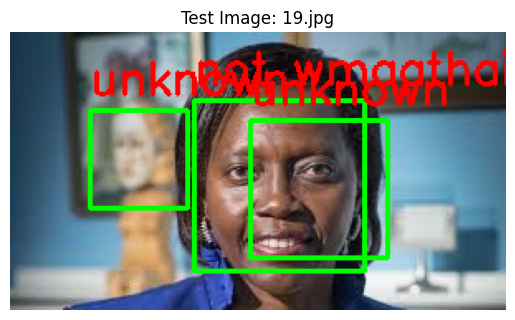

Processing image: 2.jpg
No faces detected in 2.jpg


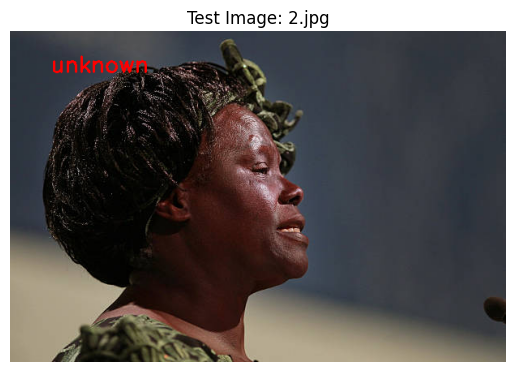

Processing image: 20.jpg
No faces detected in 20.jpg


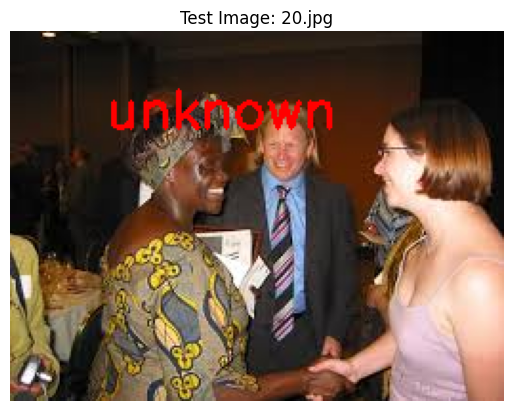

Processing image: 3.jpg
  Detected face with label: 0, confidence: 66.11244778440738
No eyes detected within face region of 3.jpg
  Detected face with label: 0, confidence: 57.76854247522477


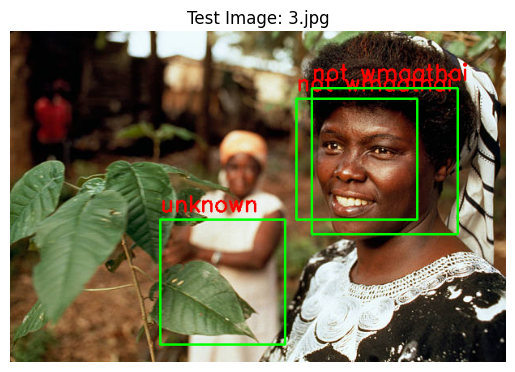

Processing image: 5.jpg
No faces detected in 5.jpg


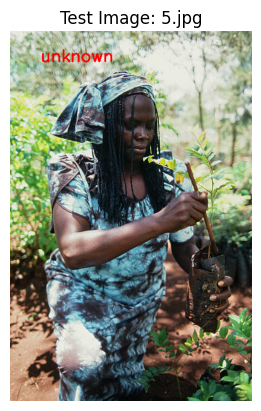

Processing image: 6.jpg
No eyes detected within face region of 6.jpg
No eyes detected within face region of 6.jpg
No eyes detected within face region of 6.jpg


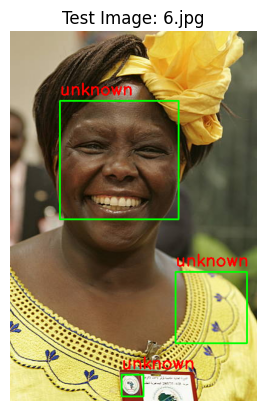

Processing image: 8.jpg
No faces detected in 8.jpg


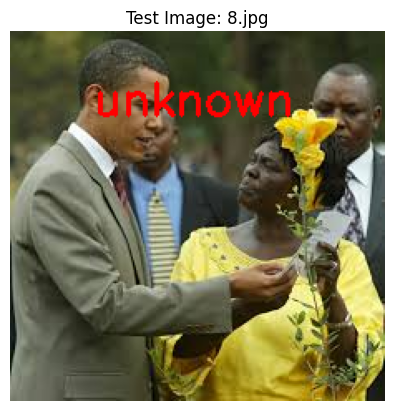

Processing image: 9.jpg
No eyes detected within face region of 9.jpg


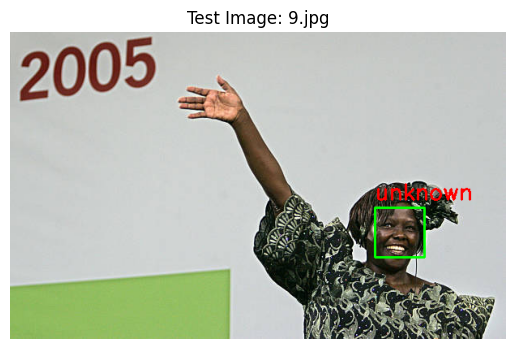

In [278]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the trained model for face recognition
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read('./trained/trained_model.yml')  # Path to the trained model

# Path to the folder containing test images
test_img_dir = 'test_images'

# Initialize Haar Cascade classifiers for frontal and side faces, and eyes
front_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
side_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Loop through the test images
for test_image_name in os.listdir(test_img_dir):
    test_image_path = os.path.join(test_img_dir, test_image_name)

    test_img = cv2.imread(test_image_path)
    if test_img is None:
        print(f"Failed to load image {test_image_path}")
        continue  # Skip invalid images

    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  # Convert test image to grayscale for face detection

    # Detect frontal and side faces
    front_faces = front_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    side_faces = side_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Combine both frontal and side faces into one list
    all_faces = []
    if len(front_faces) > 0:
        all_faces.extend(front_faces)
    if len(side_faces) > 0:
        all_faces.extend(side_faces)

    # Log the current image being processed
    print(f"Processing image: {test_image_name}")

    # If no faces were detected
    if len(all_faces) == 0:
        print(f"No faces detected in {test_image_name}")
        text = "unknown"
        color = (0, 0, 255)  # Red text for 'unknown'
        cv2.putText(test_img, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    else:
        # Process each detected face
        for (x, y, w, h) in all_faces:
            # Draw a rectangle around the detected face for debugging
            cv2.rectangle(test_img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle for face region

            face_region = test_img[y:y + h, x:x + w]  # Extract the color face region

            # Detect eyes within the face region (use color image instead of grayscale)
            eyes = eye_cascade.detectMultiScale(face_region, scaleFactor=1.1, minNeighbors=3, minSize=(30, 30))

            if len(eyes) > 0:  # If eyes are detected, proceed with face recognition
                # Recognize the face using the trained recognizer
                label, confidence = recognizer.predict(gray_img[y:y + h, x:x + w])

                # Log the label and confidence for debugging
                print(f"  Detected face with label: {label}, confidence: {confidence}")

                # Check if the confidence value is good (low confidence means a good match)
                if confidence < 100:  # Low confidence means a good match
                    if label == 1:  # Check if label corresponds to 'wmaathai'
                        text = "wmaathai"  # Only show 'wmaathai' text
                        color = (0, 255, 0)  # Green text for 'wmaathai'
                    else:
                        text = "not wmaathai"  # Show only 'not wmaathai' text
                        color = (0, 0, 255)  # Red text for 'not wmaathai'
                else:
                    # If the confidence is too high, mark the face as unknown
                    text = "unknown"  # Show only 'unknown' text
                    color = (0, 0, 255)  # Red text for 'unknown'

                # Put text on the image
                cv2.putText(test_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            else:
                # If no eyes detected within the face region
                print(f"No eyes detected within face region of {test_image_name}")
                text = "unknown"
                color = (0, 0, 255)  # Red text for 'unknown'
                cv2.putText(test_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Convert the image to RGB (from BGR, OpenCV uses BGR format)
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(test_img_rgb)
    plt.axis('off')  # Hide axes
    plt.title(f"Test Image: {test_image_name}")  # Title with the image name
    plt.show()


# Testing

In [275]:
# Load the trained model for face recognition
recognizer.read('trained/trained_model.yml')

In [ ]:
import matplotlib.pyplot as plt

# Loop through the test images
for test_image_name in os.listdir(test_img_dir):
    test_image_path = os.path.join(test_img_dir, test_image_name)

    test_img = cv2.imread(test_image_path)
    if test_img is None:
        print(f"Failed to load image {test_image_path}")
        continue  # Skip invalid images

    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  # Convert test image to grayscale for face detection

    # Detect frontal and side faces
    front_faces = front_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
    side_faces = side_face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))

    # Combine both frontal and side faces into one list
    all_faces = []
    if len(front_faces) > 0:
        all_faces.extend(front_faces)
    if len(side_faces) > 0:
        all_faces.extend(side_faces)

    # Log the current image being processed
    print(f"Processing image: {test_image_name}")

    # If no faces were detected
    if len(all_faces) == 0:
        print(f"No faces detected in {test_image_name}")
        text = "unknown"
        color = (0, 0, 255)  # Red text for 'unknown'
        cv2.putText(test_img, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    else:
        # Process each detected face
        for (x, y, w, h) in all_faces:
            # Draw a rectangle around the detected face for debugging
            cv2.rectangle(test_img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle for face region    
            
            face_region = gray_img[y:y + h, x:x + w]  # Extract the face region

            # Detect eyes within the face region
            eyes = eye_cascade.detectMultiScale(face_region, scaleFactor=1.1, minNeighbors=3, minSize=(40, 40))

            if len(eyes) > 0:  # If eyes are detected, proceed with face recognition
                # Recognize the face using the trained recognizer
                label, confidence = recognizer.predict(face_region)

                # Log the label and confidence for debugging
                print(f"  Detected face with label: {label}, confidence: {confidence}")

                # Check if the confidence value is good (low confidence means a good match)
                if confidence < 100:  # Low confidence means a good match
                    if label == 1:
                        is_wmaathai = True
                        text = "wmaathai"
                        color = (0, 255, 0)  # Green text for 'wmaathai'
                    else:
                        text = "not wmaathai"
                        color = (0, 0, 255)  # Red text for 'not wmaathai'
                else:
                # If the confidence is too high, mark the face as unknown
                    text = "unknown"
                    color = (0, 0, 255)  # Red text for 'unknown'

            # Put text on the image
                cv2.putText(test_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            else:
                # If no eyes detected within the face region
                print(f"No eyes detected within face region of {test_image_name}")
                text = "unknown"
                color = (0, 0, 255)  # Red text for 'unknown'
                cv2.putText(test_img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Convert the image to RGB (from BGR, OpenCV uses BGR format)
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(test_img_rgb)
    plt.axis('off')  # Hide axes
    plt.title(f"Test Image: {test_image_name}")  # Title with the image name
    plt.show()

In [277]:
# Draw a rectangle around the face and display the label
        # color = (0, 255, 0)  # Green color for recognized faces    
#cv2.rectangle(test_img, (x, y), (x + w, y + h), color, 2)
            #cv2.putText(test_img, f'Person {label}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        #else:
            # If the confidence is high, mark the face as unknown
            #cv2.putText(test_img, 'Unknown', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Show the result
    #cv2.imshow(f"Recognized Faces - {test_image_name}", test_img)
    # Save the result to a file instead of showing it
    #cv2.imwrite("recognized_faces.jpg", test_img)

    #cv2.waitKey(0)  # Wait for any key to close the window

#cv2.destroyAllWindows()
